# Deep Neural Network Application

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

In [3]:
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [4]:
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

train_x = train_x_flatten / 255
test_x = test_x_flatten / 255

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))
print('(n_features, m_examples)')

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)
(n_features, m_examples)


In [5]:
# Helper functions

def initialize_parameters(n_x, n_h, n_y):
  """
  Argument:
  n_x -- size of the input layer
  n_h -- size of the hidden layer
  n_y -- size of the output layer
  
  Returns:
  parameters -- python dictionary containing your parameters:
                  W1 -- weight matrix of shape (n_h, n_x)
                  b1 -- bias vector of shape (n_h, 1)
                  W2 -- weight matrix of shape (n_y, n_h)
                  b2 -- bias vector of shape (n_y, 1)
  """
  
  np.random.seed(1)

  W1 = np.random.randn(n_h, n_x) * 0.01
  b1 = np.zeros((n_h, 1))
  W2 = np.random.randn(n_y, n_h) * 0.01
  b2 = np.zeros((n_y, 1))

  assert(W1.shape == (n_h, n_x))
  assert(b1.shape == (n_h, 1))
  assert(W2.shape == (n_y, n_h))
  assert(b2.shape == (n_y, 1))
  
  parameters = {"W1": W1,
                "b1": b1,
                "W2": W2,
                "b2": b2}
  
  return parameters 


def linear_forward(A, W, b):
  """
  Implement the linear part of a layer's forward propagation.

  Arguments:
  A -- activations from previous layer (or input data): (size of previous layer, number of examples)
  W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
  b -- bias vector, numpy array of shape (size of the current layer, 1)

  Returns:
  Z -- the input of the activation function, also called pre-activation parameter 
  cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
  """

  Z = np.dot(W, A) + b

  assert(Z.shape == (W.shape[0], A.shape[1]))
  cache = (A, W, b)
  
  return Z, cache


def linear_activation_forward(A_prev, W, b, activation):
  """
  Implement the forward propagation for the LINEAR->ACTIVATION layer

  Arguments:
  A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
  W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
  b -- bias vector, numpy array of shape (size of the current layer, 1)
  activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

  Returns:
  A -- the output of the activation function, also called the post-activation value 
  cache -- a python tuple containing "linear_cache" and "activation_cache";
            stored for computing the backward pass efficiently
  """

  Z, linear_cache = linear_forward(A_prev, W, b)

  if activation == 'sigmoid':
    A, activation_cache = sigmoid(Z)
  elif activation == 'relu':
    A, activation_cache = relu(Z)
  else:
      raise ValueError('Invalid activation')

  assert (A.shape == (W.shape[0], A_prev.shape[1]))
  cache = (linear_cache, activation_cache)

  return A, cache



def compute_cost(AL, Y):
  """
  Implement the cost function defined by equation (7).

  Arguments:
  AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
  Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

  Returns:
  cost -- cross-entropy cost
  """
  
  m = Y.shape[1]

  # Compute loss from aL and y.
  cost = - (1/m) * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL), axis=1)

  cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
  assert(cost.shape == ())
  
  return cost



def linear_backward(dZ, cache):
  """
  Implement the linear portion of backward propagation for a single layer (layer l)

  Arguments:
  dZ -- Gradient of the cost with respect to the linear output (of current layer l)
  cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

  Returns:
  dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
  dW -- Gradient of the cost with respect to W (current layer l), same shape as W
  db -- Gradient of the cost with respect to b (current layer l), same shape as b
  """
  A_prev, W, b = cache
  m = A_prev.shape[1]

  dW = (1/m) * np.dot(dZ, A_prev.T)
  db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
  dA_prev = np.dot(W.T, dZ)

  assert (dA_prev.shape == A_prev.shape)
  assert (dW.shape == W.shape)
  assert (db.shape == b.shape)
  
  return dA_prev, dW, db



def linear_activation_backward(dA, cache, activation):
  """
  Implement the backward propagation for the LINEAR->ACTIVATION layer.
  
  Arguments:
  dA -- post-activation gradient for current layer l 
  cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
  activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
  
  Returns:
  dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
  dW -- Gradient of the cost with respect to W (current layer l), same shape as W
  db -- Gradient of the cost with respect to b (current layer l), same shape as b
  """
  linear_cache, activation_cache = cache
  
  if activation == "relu":
      dZ = relu_backward(dA, activation_cache)
      dA_prev, dW, db  = linear_backward(dZ, linear_cache)
      
  elif activation == "sigmoid":
      dZ = sigmoid_backward(dA, activation_cache)
      dA_prev, dW, db  = linear_backward(dZ, linear_cache)
  else:
      raise ValueError('Invalid activation requested')
  
  return dA_prev, dW, db



def update_parameters(parameters, grads, learning_rate):
  """
  Update parameters using gradient descent
  
  Arguments:
  parameters -- python dictionary containing your parameters 
  grads -- python dictionary containing your gradients, output of L_model_backward
  
  Returns:
  parameters -- python dictionary containing your updated parameters 
                parameters["W" + str(l)] = ... 
                parameters["b" + str(l)] = ...
  """
  
  L = len(parameters) // 2 # number of layers in the neural network

  # Update rule for each parameter. Use a for loop.
  for l in range(L):
    parameters['W' + str(l + 1)] = parameters['W' + str(l + 1)] - learning_rate * grads['dW' + str(l + 1)]
    parameters['b' + str(l + 1)] = parameters['b' + str(l + 1)] - learning_rate * grads['db' + str(l + 1)]


  return parameters

In [6]:
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [7]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
  """
  Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
  
  Arguments:
  X -- input data, of shape (n_x, number of examples)
  Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
  layers_dims -- dimensions of the layers (n_x, n_h, n_y)
  num_iterations -- number of iterations of the optimization loop
  learning_rate -- learning rate of the gradient descent update rule
  print_cost -- If set to True, this will print the cost every 100 iterations 
  
  Returns:
  parameters -- a dictionary containing W1, W2, b1, and b2
  """
  
  np.random.seed(1)
  grads = {}
  costs = []                              # to keep track of the cost
  m = X.shape[1]                           # number of examples
  (n_x, n_h, n_y) = layers_dims
  
  # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
  parameters  = initialize_parameters(n_x, n_h, n_y)
  
  # Get W1, b1, W2 and b2 from the dictionary parameters.
  W1 = parameters["W1"]
  b1 = parameters["b1"]
  W2 = parameters["W2"]
  b2 = parameters["b2"]
  
  # Loop (gradient descent)

  for i in range(0, num_iterations):

      # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
      A1, cache1 = linear_activation_forward(
          X,
          W1,
          b1,
          activation='relu'
      )

      A2, cache2 = linear_activation_forward(
          A1,
          W2,
          b2,
          activation='sigmoid'
      )
      
      # Compute cost
      cost = compute_cost(A2, Y)
      
      # Initializing backward propagation
      dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
      
      # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
      dA1, dW2, db2 = linear_activation_backward(
          dA2,
          cache2,
          activation='sigmoid'
      )
      dA0, dW1, db1 = linear_activation_backward(
          dA1,
          cache1,
          activation='relu'
      )
      
      # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
      grads['dW1'] = dW1
      grads['db1'] = db1
      grads['dW2'] = dW2
      grads['db2'] = db2
      
      # Update parameters.
      parameters = update_parameters(
          parameters,
          grads,
          learning_rate
      )

      # Retrieve W1, b1, W2, b2 from parameters
      W1 = parameters["W1"]
      b1 = parameters["b1"]
      W2 = parameters["W2"]
      b2 = parameters["b2"]
      
      # Print the cost every 100 training example
      if print_cost and i % 100 == 0:
          print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
      if print_cost and i % 100 == 0:
          costs.append(cost)
      
  # plot the cost

  plt.plot(np.squeeze(costs))
  plt.ylabel('cost')
  plt.xlabel('iterations (per hundreds)')
  plt.title("Learning rate =" + str(learning_rate))
  plt.show()
  
  return parameters

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.5158304772764729
Cost after iteration 600: 0.4754901313943325
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.4007977536203885
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366412
Cost after iteration 1100: 0.3052753636196265
Cost after iteration 1200: 0.27491377282130164
Cost after iteration 1300: 0.2468176821061486
Cost after iteration 1400: 0.19850735037466094
Cost after iteration 1500: 0.17448318112556635
Cost after iteration 1600: 0.1708076297809693
Cost after iteration 1700: 0.11306524562164719
Cost after iteration 1800: 0.09629426845937154
Cost after iteration 1900: 0.08342617959726871
Cost after iteration 2000: 0.0743907870431909
Cost after iteration 2100: 0.066307481322

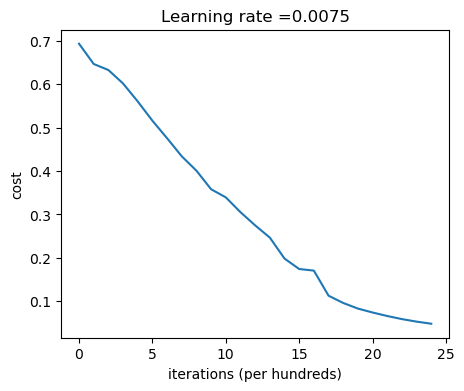

In [8]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)


In [9]:
predictions_train = predict(train_x, train_y, parameters)
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.9999999999999998
Accuracy: 0.72


In [10]:
# Helper functions

def initialize_parameters_deep(layer_dims):
  """
  Arguments:
  layer_dims -- python array (list) containing the dimensions of each layer in our network
  
  Returns:
  parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                  Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                  bl -- bias vector of shape (layer_dims[l], 1)
  """
  
  np.random.seed(3)
  parameters = {}
  L = len(layer_dims)            # number of layers in the network

  for l in range(1, L):
    nx = layer_dims[l]
    nx_prev = layer_dims[l - 1]
    parameters['W' + str(l)] = np.random.randn(nx, nx_prev) * 0.01
    parameters['b' + str(l)] = np.zeros((nx, 1))
    assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
    assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

      
  return parameters


def L_model_forward(X, parameters):
  """
  Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
  
  Arguments:
  X -- data, numpy array of shape (input size, number of examples)
  parameters -- output of initialize_parameters_deep()
  
  Returns:
  AL -- last post-activation value
  caches -- list of caches containing:
              every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
  """

  caches = []
  A = X
  L = len(parameters) // 2                  # number of layers in the neural network
  
  # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
  for l in range(1, L):
      A_prev = A 
      ### START CODE HERE ### (≈ 2 lines of code)
      A, cache = linear_activation_forward(A, parameters['W' + str(l)], parameters['b' + str(l)], 'relu')
      caches.append(cache)
      ### END CODE HERE ###
  
  # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
  ### START CODE HERE ### (≈ 2 lines of code)
  AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], 'sigmoid')
  caches.append(cache)
  ### END CODE HERE ###
  
  assert(AL.shape == (1,X.shape[1]))
          
  return AL, caches

def L_model_backward(AL, Y, caches):
  """
  Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
  
  Arguments:
  AL -- probability vector, output of the forward propagation (L_model_forward())
  Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
  caches -- list of caches containing:
              every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
              the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
  
  Returns:
  grads -- A dictionary with the gradients
            grads["dA" + str(l)] = ... 
            grads["dW" + str(l)] = ...
            grads["db" + str(l)] = ... 
  """
  grads = {}
  L = len(caches) # the number of layers
  m = AL.shape[1]
  Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
  
  # Initializing the backpropagation
  dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
  
  # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
  current_cache = caches[L - 1]
  grads["dA" + str(L - 1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(
    dAL,
    current_cache,
    activation='sigmoid'
  )

  # Loop from l=L-2 to l=0
  for l in reversed(range(L-1)):
    current_cache = caches[l]
      # lth layer: (RELU -> LINEAR) gradients.
      # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
    grads["dA" + str(l)], grads["dW" + str(l + 1)], grads["db" + str(l + 1)] = linear_activation_backward(
      grads['dA' + str(l + 1)],
      current_cache,
      activation='relu'
    )


  return grads




In [11]:
layers_dims = [12288, 20, 7, 5, 1]

In [17]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
  """
  Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
  
  Arguments:
  X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
  Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
  layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
  learning_rate -- learning rate of the gradient descent update rule
  num_iterations -- number of iterations of the optimization loop
  print_cost -- if True, it prints the cost every 100 steps
  
  Returns:
  parameters -- parameters learnt by the model. They can then be used to predict.
  """

  np.random.seed(1)
  costs = []
  
  # Parameters initialization. (≈ 1 line of code)
  parameters = initialize_parameters_deep(layers_dims)
  
  # Loop (gradient descent)
  for i in range(0, num_iterations):
    # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
    AL, caches = L_model_forward(X, parameters)
    
    # Compute cost.
    cost = compute_cost(AL, Y)

    # Backward propagation.
    grads = L_model_backward(AL, Y, caches)

    # Update parameters.
    parameters = update_parameters(
        parameters,
        grads,
        learning_rate
    )
            
    # Print the cost every 100 training example
    if print_cost and i % 100 == 0:
        print ("Cost after iteration %i: %f" %(i, cost))
    if print_cost and i % 100 == 0:
        costs.append(cost)
          
  # plot the cost
  plt.plot(np.squeeze(costs))
  plt.ylabel('cost')
  plt.xlabel('iterations (per hundreds)')
  plt.title("Learning rate =" + str(learning_rate))
  plt.show()
  
  return parameters

Cost after iteration 0: 0.693148
Cost after iteration 100: 0.678011
Cost after iteration 200: 0.667600
Cost after iteration 300: 0.660422
Cost after iteration 400: 0.655458
Cost after iteration 500: 0.652013
Cost after iteration 600: 0.649616
Cost after iteration 700: 0.647942
Cost after iteration 800: 0.646770
Cost after iteration 900: 0.645947
Cost after iteration 1000: 0.645368
Cost after iteration 1100: 0.644961
Cost after iteration 1200: 0.644673
Cost after iteration 1300: 0.644469
Cost after iteration 1400: 0.644325
Cost after iteration 1500: 0.644223
Cost after iteration 1600: 0.644151
Cost after iteration 1700: 0.644100
Cost after iteration 1800: 0.644063
Cost after iteration 1900: 0.644037
Cost after iteration 2000: 0.644019
Cost after iteration 2100: 0.644006
Cost after iteration 2200: 0.643997
Cost after iteration 2300: 0.643990
Cost after iteration 2400: 0.643985


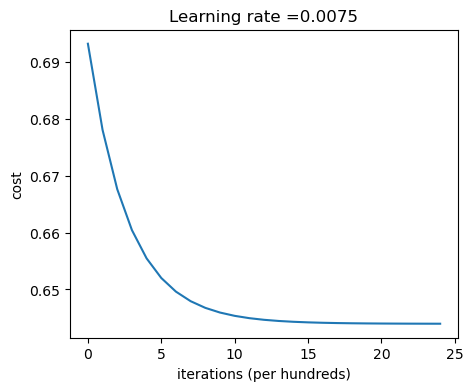

In [13]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [14]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.6555023923444976


In [15]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.3400000000000001


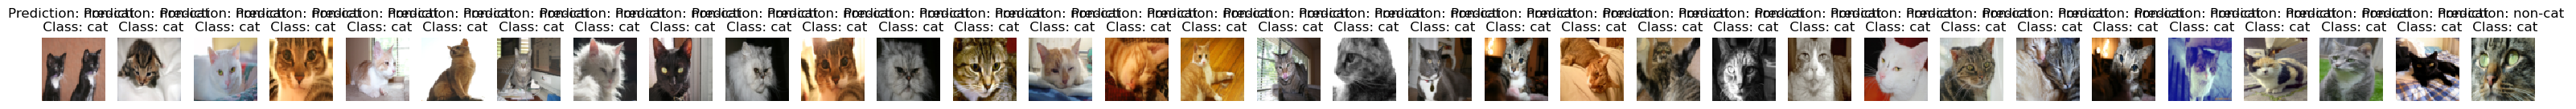

In [20]:
print_mislabeled_images(classes, test_x, test_y, pred_test)